In [1]:
# imports
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as c
from matplotlib import rcParams
import sympy as sy
import scipy.constants as pc
from sympy import *
from math import log10, floor

rcParams['font.size'] = 16
rcParams['font.weight'] = 'bold'
rcParams['text.usetex'] = True
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Helvetica']

In [2]:
# Funktionen
def am(werte):
    return np.mean(werte)

def std(werte):
    summen_der_quadrate = 0
    for wert in werte:
        summen_der_quadrate+=(wert-am(werte))**2       
    return np.sqrt(summen_der_quadrate/(werte.size-1))

def stu(werte):
    return std(werte)/np.sqrt(werte.size)

def fehler(f, werte, unsicherheiten, variablen):
    zMax = 0
    for i in range(werte.size):
        dif = np.abs(sy.diff(f, variablen[i]))
        zMax += (dif * unsicherheiten[i])**2
    zMax = sqrt(zMax)
    for j in range(werte.size):
        zMax = sub(zMax, variablen[j], werte[j])
    return zMax

def fehlerMax(f, werte, unsicherheiten, variablen):
    zMax = 0
    for i in range(werte.size):
        dif = np.abs(sy.diff(f, variablen[i]))
        zMax += dif * unsicherheiten[i]
    for j in range(werte.size):
        zMax = sub(zMax, variablen[j], werte[j])
    return zMax

def groessterBeitrag(f, werte, unsicherheiten, variablen):
    zMax = 0
    zMaxArray = np.array([])
    for i in range (werte.size):
        zMax = (np.abs(sy.diff(f, variablen[i])) * unsicherheiten[i])
        for j in range(werte.size):
            zMax = sub(zMax, variablen[j], werte[j])
        x = np.array([zMax])
        zMaxArray = np.append(zMaxArray, x)
    return variablen[np.argmax(zMaxArray)]

def sub(zMax, variable, wert):
    return zMax.subs([(variable, wert)])

def einfachGaussAdd(unsicherheiten, koeffizienten):
    dz = 0
    for i in range (unsicherheiten.size):
        dz += (unsicherheiten[i]*unsicherheiten[i])**2
    return sqrt(dz)

def einfachGaussMult(unsicherheiten, werte, exponenten):
    dz = 0
    for i in range (unsicherheiten.size):
        dz += (exponenten[i]*unsicherheiten[i]/werte[i])**2
    return sqrt(dz)

def einfachGaussMultMax(unsicherheiten, werte, exponenten):
    max_a = 0
    num = -1
    for i in range (unsicherheiten.size):
        maxi = (exponenten[i]*unsicherheiten[i]/werte[i])**2
        if max_a <= maxi:
            max_a = maxi
            num = i
    return (max_a, num)

def vertraeglichkeit(am_1, am_2, stu_1, stu_2):
    return (np.abs(am_1-am_2)/(sqrt((stu_1**2)*(stu_2**2))))

def bestA(x, y):
    return (sum(x**2)*sum(y)-sum(x)*sum(x*y))/(x.size*sum(x**2)-sum(x)**2)

def bestB(x, y):
    return (x.size*sum(x*y)-sum(x)*sum(y))/(x.size*sum(x**2)-sum(x)**2)

def streuung(x, y):
    s = 0
    for i in range(x.size):
        s += (y[i]-(bestA(x, y)+bestB(x, y)*x[i]))**2
    return np.sqrt(s/(x.size-2))

def stuA(x, y):
    s = streuung(x, y)
    return s*np.sqrt(sum(x**2)/((x.size*sum(x**2)-sum(x)**2)))

def stuB(x, y):
    s = streuung(x, y)
    return s*np.sqrt(x.size/((x.size*sum(x**2)-sum(x)**2)))

def round_to_j(x,j):
    return round(x, (j-1)-int(floor(log10(abs(x)))))

def print_to_table(avgs, stds, rows, cols,
                   highlight_best=True,
                   max_is_best=True,
                   avg_format='{0:!>4.1f}',
                   std_format='{1:!<4.1f}',
                   file=None,
                   col_orientation='c'):
    # Find best values
    best_avg = {}
    if highlight_best:
        if max_is_best:
            for c in cols:
                idx = np.argmax(avgs[c], axis=0)
                best_avg[c] = idx
        else:
            for c in cols:
                idx = np.argmin(avgs[c], axis=0)
                best_avg[c] = idx

    # Header
    print_str = '\\begin{tabular}{l' + (" "+col_orientation) * len(cols) + '} \hline\n'
    for c in cols:
        print_str += ' & ' + c
    print_str += ' \\\\ \n \hline'

    # Content
    for m in range(len(rows)):
        row_name = rows[m]
        print_str += '\n{0}'.format(row_name)
        for c in cols:
            print_str += ' &\n '
            print_list = [avgs[c][m]]
            print_list += [stds[c][m]]
            if m == best_avg.get(c, None):
                print_str += ('$\mathbf{{'+ avg_format + ' \\pm ' + std_format + '}}$').format(*print_list)
            else:
                print_str += ('$'+ avg_format + ' \\pm ' + std_format + '$').format(*print_list)

        print_str += "\n \\vspace*{0.0mm} \\\\"
        print_str = print_str.replace('!', '\\phantom{0}')

    # Footer
    print_str += '\n \hline \n \end{tabular}'

    # Write output
    if file is None:
        print(print_str)
    else:
        with open(file, 'w') as f:
            f.write(print_str)

In [3]:
# Erinnerungen
# x = np.array([,])
# x.size
# x, y = symbols('x y')
# expr = x*y
# expr.subs([(x, wert_x), (y, wert_y)])

In [4]:
# Messungen
laengen = np.array([845.3, 745.3, 645.3, 545.3, 445.3, 345.3, 245.3, 145.3, 45.3])# 0.1 mm
zeiten = np.array([20.87, 20.31, 19.82, 19.44, 19.23, 19.28, 19.72, 20.75, 22.79])
zeitenR = np.array([20.29, 19.99, 19.77, 19.62, 19.56, 19.62, 19.81, 20.15, 20.64])
n = 10

perT = zeiten/n 
perTR = zeitenR/n

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


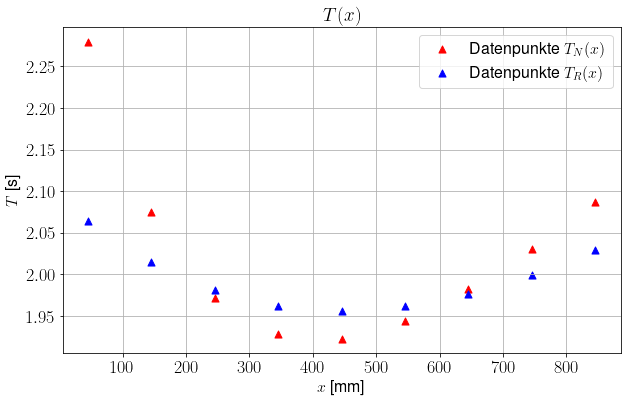

In [5]:
# Standard plotting

fig, ax = plt.subplots(figsize=(10,6))
ax.tick_params(axis='both', which='major', labelsize=18)
ax.tick_params(axis='both', which='minor', labelsize=16)


x = np.linspace(0, 900, 50)

z = np.polyfit(laengen,perT, 4)
zR = np.polyfit(laengen,perTR, 2)

ax.scatter(laengen, perT, color='r',s=50 ,marker=r'^', label=r'Datenpunkte $T_N(x)$')
ax.scatter(laengen, perTR, color='b',s=50,  marker=r'^', label=r'Datenpunkte $T_R(x)$')
#ax.plot(x, z[4]+z[3]*x+z[2]*x*x+z[1]*x**3+z[0]*x**4, color='y', label='Regressionsgerade T(x) Normalaufhängepunkt')
#ax.plot(x, zR[2]+zR[1]*x+zR[0]*x*x, color='cyan', label='Regressionsgerade T(x) Reversionsaufhängepunkt')
#ax.errorbar(am_x, am_y, xerr=std_x, yerr=std_y, fmt='D', color='#d0740b', label='label')

ax.set(xlabel=r'$x$  [mm]', ylabel=r'$T$  [s]', title=r'$T(x)$')
ax.legend()
ax.grid()

fig.savefig("T(x).png")

In [6]:
# Messungen
laengen2= np.array([695.3, 690.3, 685.3, 680.3, 675.3, 670.3, 665.3, 660.3, 655.3, 
                    650.3, 645.3, 640.3, 635.3, 630.3, 625.3, 620.3, 615.3])# 615.3, 610.3, 605.3])# 0.1 mm
zeiten2 = np.array([30.08, 30.06, 30.02, 29.98, 29.94, 29.90, 29.87, 29.81, 29.79, 29.75, 
                    29.72, 29.69, 29.65, 29.59, 29.54, 29.49, 29.52])
zeitenR2 = np.array([29.92, 29.88, 29.84, 29.86, 29.84, 29.81, 29.76, 29.77, 29.72, 29.72, 
                     29.71, 29.69, 29.66, 29.65, 29.62, 29.61, 29.59])
n2 = 15

perT2 = zeiten2/n2 
perTR2 = zeitenR2/n2

[B, A] [US B, US A] Normal [0.0005049019607845389, 1.6550200980388121] [1.0495234267507403e-05, 0.006882330115178816]
[B, A] [US B, US A] Revers [0.00026568627450982134, 1.8088369607843082] [9.034041685769672e-06, 0.0059241419077460875]


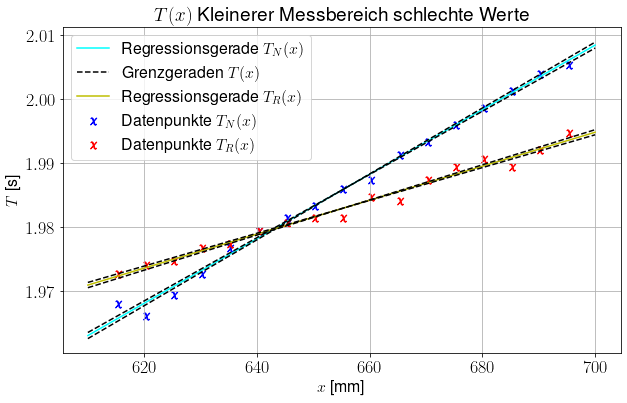

In [7]:
fig, ax = plt.subplots(figsize=(10,6))
ax.tick_params(axis='both', which='major', labelsize=18)
ax.tick_params(axis='both', which='minor', labelsize=16)

x2 = np.linspace(610, 700, 40)

z2 = [bestB(laengen2,perT2), bestA(laengen2,perT2)]
z2u = [stuB(laengen2,perT2), stuA(laengen2,perT2)]

ax.scatter(laengen2, perT2, color='b',s=50 ,marker=r'$\chi$', label=r'Datenpunkte $T_N(x)$')

ax.plot(x2, z2[1]+z2[0]*x2, color='cyan', label=r'Regressionsgerade $T_N(x)$')

ax.plot(x2, x2*(z2[0]-z2u[0])+z2[1]+z2u[1], color='black', linestyle='--',label=r'Grenzgeraden $T(x)$')
ax.plot(x2, x2*(z2[0]+z2u[0])+z2[1]-z2u[1], color='black', linestyle='--')


zR2 = [bestB(laengen2,perTR2), bestA(laengen2,perTR2)]
zR2u = [stuB(laengen2,perTR2), stuA(laengen2,perTR2)]

ax.scatter(laengen2, perTR2, color='r', s=50,  marker=r'$\chi$', label=r'Datenpunkte $T_R(x)$')

ax.plot(x2, zR2[1]+zR2[0]*x2, color='y', label=r'Regressionsgerade $T_R(x)$')

ax.plot(x2, x2*(zR2[0]-zR2u[0])+zR2[1]+zR2u[1], color='black', linestyle='--')
ax.plot(x2, x2*(zR2[0]+zR2u[0])+zR2[1]-zR2u[1], color='black', linestyle='--')

ax.set(xlabel=r'$x$ [mm]', ylabel=r'$T$ [s]', title=r'$T(x)$ Kleinerer Messbereich schlechte Werte') 
ax.legend()
ax.grid()

fig.savefig("T(x)2.png")

print('[B, A] [US B, US A] Normal', z2, z2u)
print('[B, A] [US B, US A] Revers', zR2, zR2u)

In [8]:
# Messungen
laengen3 = np.array([695.3, 685.3, 675.3, 665.3, 655.3, 645.3, 635.3, 625.3, 615.3, 605.3])# 0.1 mm

zeiten3 =  np.array([20.03, 19.98, 19.94, 19.89, 19.85, 19.80, 19.75, 19.71, 19.67, 19.63])
zeitenR3 = np.array([19.94, 19.90, 19.88, 19.85, 19.82, 19.79, 19.77, 19.74, 19.73, 19.71])

n3 = 10

perT3 = zeiten3/n3 
perTR3 = zeitenR3/n3

1.9796
[B, A] [US B, US A] Normal [0.0004478787878785212, 1.6912444242427813] [4.9049739564359065e-06, 0.0031928143838349443]
[B, A] [US B, US A] Revers [0.0002563636363634589, 1.8145867272730527] [9.447549859469134e-06, 0.006149731548264749]


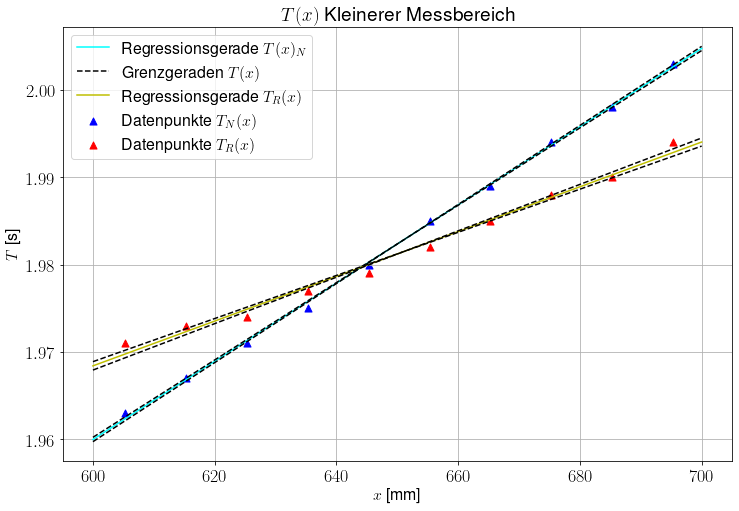

In [9]:
fig, ax = plt.subplots(figsize=(12,8))
ax.tick_params(axis='both', which='major', labelsize=18)
ax.tick_params(axis='both', which='minor', labelsize=16)


x3 = np.linspace(600, 700, 200)

z3 = [bestB(laengen3,perT3), bestA(laengen3,perT3)]#np.polyfit(laengen3,perT3, 1)
z3u = [stuB(laengen3,perT3), stuA(laengen3,perT3)]

ax.scatter(laengen3, perT3, color='b',s=50 ,marker=r'^', label=r'Datenpunkte $T_N(x)$')

ax.plot(x3, z3[1]+z3[0]*x3, color='cyan', label=r'Regressionsgerade $T(x)_N$ ')

ax.plot(x3, x3*(z3[0]-z3u[0])+z3[1]+z3u[1], color='black', linestyle='--',label=r'Grenzgeraden $T(x)$')
ax.plot(x3, x3*(z3[0]+z3u[0])+z3[1]-z3u[1], color='black', linestyle='--')

zR3 = [bestB(laengen3,perTR3), bestA(laengen3,perTR3)]
zR3u = [stuB(laengen3,perTR3), stuA(laengen3,perTR3)]

ax.scatter(laengen3, perTR3, color='r',s=50,  marker=r'^', label=r'Datenpunkte $T_R(x)$ ')

ax.plot(x3, zR3[1]+zR3[0]*x3, color='y', label=r'Regressionsgerade $T_R(x)$ ')

ax.plot(x3, x3*(zR3[0]-zR3u[0])+zR3[1]+zR3u[1], color='black', linestyle='--')
ax.plot(x3, x3*(zR3[0]+zR3u[0])+zR3[1]-zR3u[1], color='black', linestyle='--')


ax.set(xlabel=r'$x$ [mm]', ylabel=r'$T$ [s]', title=r'$T(x)$ Kleinerer Messbereich') 
ax.legend()
ax.grid()

fig.savefig("T(x)3.png")

for i in x3:
    if round(zR3[1]+zR3[0]*i, 4) == round(z3[1]+z3[0]*i, 4):
        print(round(z3[1]+z3[0]*i, 4))
    
print('[B, A] [US B, US A] Normal', z3, z3u)
print('[B, A] [US B, US A] Revers', zR3, zR3u)

In [10]:
#Messungen

winkel = np.array([2, 5, 7, 10, 12, 15, 17, 20]) #2°   

zeiten4 = np.array([19.79, 19.81, 19.81, 19.84, 19.85, 19.86, 19.91, 19.91])

n4 = 10

perT4 = zeiten4/n4

[B, A] [US B, US A] Normal [0.0007052238805968826, 1.9769925373134332] [7.146602090335616e-05, 0.0008883085534940866]


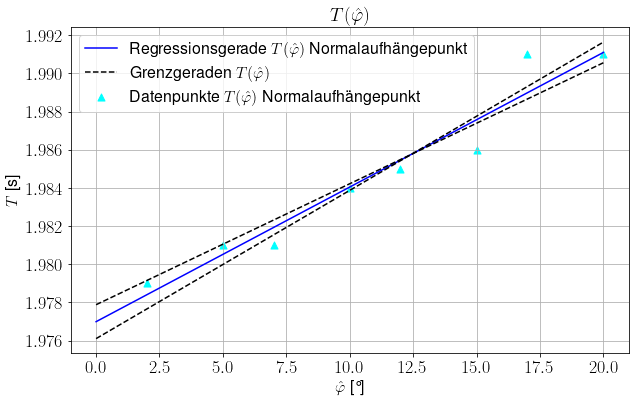

In [11]:
# Standard plotting

fig, ax = plt.subplots(figsize=(10,6))
ax.tick_params(axis='both', which='major', labelsize=18)
ax.tick_params(axis='both', which='minor', labelsize=16)

x4 = np.linspace(0, 20, 20)

z4 = [bestB(winkel,perT4), bestA(winkel,perT4)]
z4u = [stuB(winkel,perT4), stuA(winkel,perT4)]

ax.scatter(winkel, perT4, color='cyan',s=50 ,marker=r'^', label=r'Datenpunkte $T(\hat{\varphi})$ Normalaufhängepunkt')

ax.plot(x4, z4[1]+z4[0]*x4, color='b', label=r'Regressionsgerade $T(\hat{\varphi})$ Normalaufhängepunkt')

ax.plot(x4, x4*(z4[0]-z4u[0])+z4[1]+z4u[1], color='black', linestyle='--',label=r'Grenzgeraden $T(\hat{\varphi})$')
ax.plot(x4, x4*(z4[0]+z4u[0])+z4[1]-z4u[1], color='black', linestyle='--')


ax.set(xlabel=r'$\hat{\varphi}$ [°]', ylabel=r'$T$ [s]', title=r'$T(\hat{\varphi})$') 
ax.legend()
ax.grid()

fig.savefig("T(p).png")

print('[B, A] [US B, US A] Normal', z4, z4u)

[B, A] [US B, US A] Normal [3.1015902221054364e-05, 1.979958043106847] [3.443522597029326e-06, 0.0006971793982695495]


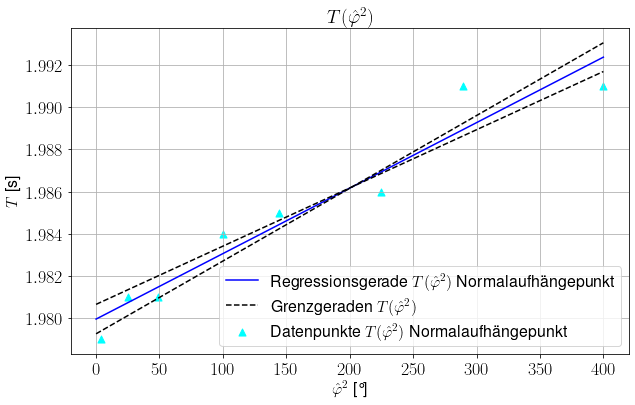

In [12]:
fig, ax = plt.subplots(figsize=(10,6))
ax.tick_params(axis='both', which='major', labelsize=18)
ax.tick_params(axis='both', which='minor', labelsize=16)

winkelq = winkel**2

x4q = (np.linspace(0, 20, 20))**2

z4q = [bestB(winkelq,perT4), bestA(winkelq,perT4)]
z4qu = [stuB(winkelq,perT4), stuA(winkelq,perT4)]

ax.scatter(winkelq, perT4, color='cyan',s=50 ,marker=r'^', label=r'Datenpunkte $T(\hat{\varphi}^2)$ Normalaufhängepunkt')

ax.plot(x4q, z4q[1]+z4q[0]*x4q, color='b', label=r'Regressionsgerade $T(\hat{\varphi}^2)$ Normalaufhängepunkt')

ax.plot(x4q, x4q*(z4q[0]-z4qu[0])+z4q[1]+z4qu[1], color='black', linestyle='--',label=r'Grenzgeraden $T(\hat{\varphi}^2)$')
ax.plot(x4q, x4q*(z4q[0]+z4qu[0])+z4q[1]-z4qu[1], color='black', linestyle='--')


ax.set(xlabel=r'$\hat{\varphi}^2$ [°]', ylabel=r'$T$ [s]', title=r'$T(\hat{\varphi}^2)$') 
ax.legend()
ax.grid()

fig.savefig("T(p2).png")

print('[B, A] [US B, US A] Normal', z4q, z4qu)

$$
T=2\pi\sqrt{\frac{l}{g}}\iff g=\frac{4\pi^{2}l}{T^{2}}
$$

In [13]:
l = (970)/1000
t = 1.9796

g = (4*(pc.pi**2)*l)/(t**2)



print(g)
#print(stu(g)/am(g))

9.771845249363958


In [14]:
print(pc.pi)

3.141592653589793
